# Tiny Chronicler @( * O * )@

Generate a MIDI score from an audio file by finding significant musical events in it (via onset detection) and applying suiting musical MIDI fragments aka "modules".

This is a script for testing and development of the "Tiny Chronicler" and will be integrated into the actual program one day.

In [19]:
import sys
import warnings
import os
import math
import random
import datetime

import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import pretty_midi
from IPython.display import Audio

warnings.filterwarnings("ignore")

## Original Audio Source

In [24]:
input_audio = './files/wav/voice.wav'
maximum_duration = 30

# Read audio file and convert to mono
assert os.path.exists(input_audio)
y, sr = librosa.load(input_audio, duration=maximum_duration)
print("Read audio file: {} @ {}hz".format(input_audio, sr))
Audio(data=y, rate=sr)

Read audio file: ./files/wav/voice.wav @ 22050hz


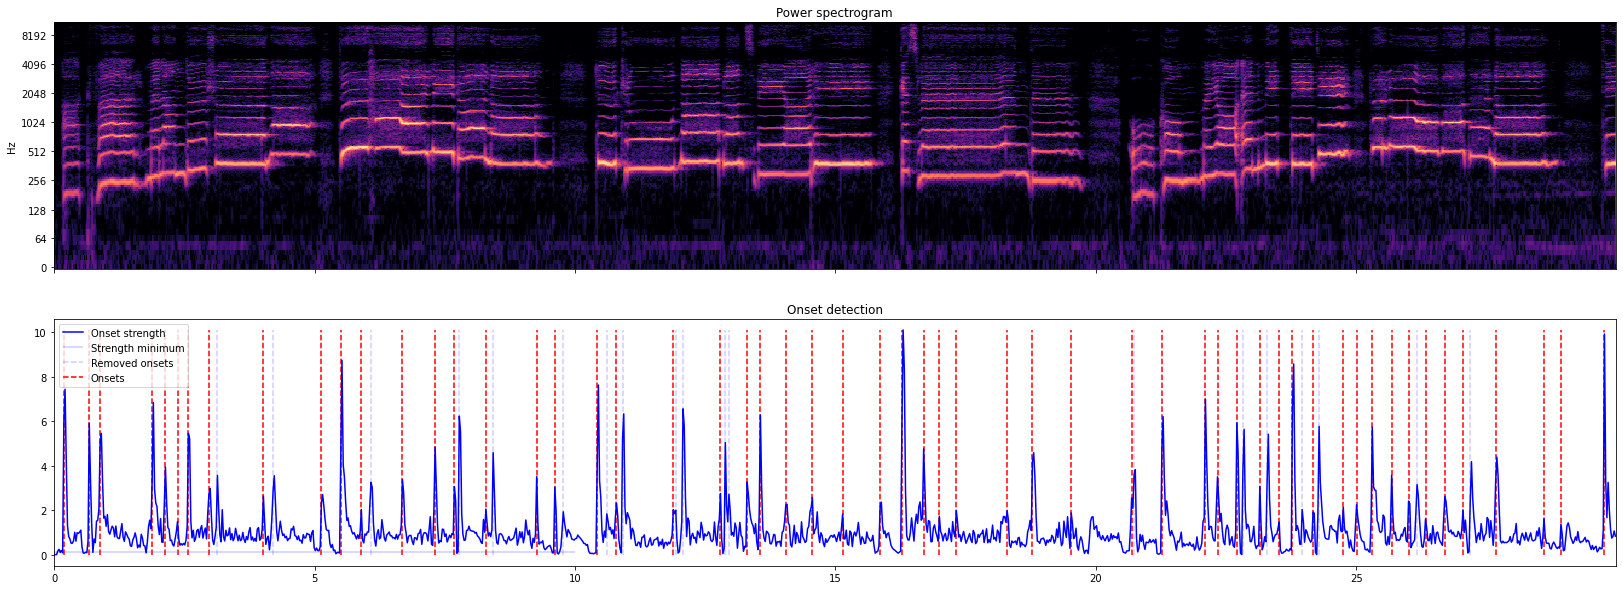

In [26]:
# Ignore onsets under this threshold
onset_threshold = 0.1
# Remove onsets which are too close to each other (in seconds)
onset_min_duration = 0.2

def remove_close_onsets(onset_frames, onset_env_times, min_duration=0.1):
    # Convert frames to time
    onset_times = onset_env_times[onset_frames]
    
    # Always add the first onset to the array
    onset_cleaned = []
    
    # Remove onsets which are too close to each other
    start_index = 0
    while start_index <= len(onset_times) - 1:
        start_time = onset_times[start_index]
        found = False
        
        for index, end_time in enumerate(onset_times[start_index + 1:]):
            end_index = index + start_index + 1
            end_time = onset_times[end_index]
            duration = end_time - start_time
            
            # Add onset when long enough duration or last event
            if duration >= min_duration or end_index == len(onset_times) - 2:
                onset_cleaned.append(onset_frames[start_index])
                start_index = end_index
                found = True
                break
                
        if not found:
            onset_cleaned.append(onset_frames[start_index])
            break
            
    return onset_cleaned


def detect_onsets(y, sr, threshold=0.2):
    # Get the frame->beat strength profile
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Locate note onset events
    onset_frames = librosa.onset.onset_detect(y=y,
                                              sr=sr,
                                              onset_envelope=onset_envelope)
    
    # Remove onsets which signals are too low
    onset_frames = [o for o in onset_frames if onset_envelope[o] >= threshold]
    
    # Convert frames to time
    onset_env_times = librosa.times_like(onset_envelope, sr=sr)
    return onset_frames, onset_envelope, onset_env_times


def plot_onsets(y, onset_frames, onset_frames_old, onset_env,
                onset_env_times, onset_frames_times):
    D = np.abs(librosa.stft(y))
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(28, 10))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                             x_axis='time',
                             y_axis='log',
                             ax=ax[0])
    ax[0].set(title='Power spectrogram')
    ax[0].label_outer()
    ax[1].set(title='Onset detection')
    ax[1].plot(onset_env_times, onset_env, color='b', label='Onset strength')
    ax[1].hlines(onset_threshold, 0, 10, color='b', alpha=0.2, label='Strength minimum')
    ax[1].vlines(np.setdiff1d(onset_env_times[onset_frames_old], onset_frames_times), 0, onset_env.max(),
                 color='b',
                 alpha=0.2,
                 linestyle='--',
                 label='Removed onsets')
    ax[1].vlines(onset_frames_times, 0, onset_env.max(),
                 color='r',
                 alpha=1,
                 linestyle='--',
                 label='Onsets')
    ax[1].legend()


# Detect onsets
onset_frames_old, onset_env, onset_env_times = detect_onsets(y,
                                                             sr=sr,
                                                             threshold=onset_threshold)
onset_frames = remove_close_onsets(onset_frames_old, onset_env_times,
                                   min_duration=onset_min_duration)
onset_frames_times = onset_env_times[onset_frames]

# Show diagram
plot_onsets(y, onset_frames, onset_frames_old, onset_env,
            onset_env_times, onset_frames_times)

In [27]:
# Render test audio with onset clicks
test_click_audio = librosa.clicks(times=onset_frames_times, sr=sr, length=len(y))
Audio(data=test_click_audio+y, rate=sr)

## MIDI modules

In [28]:
# Load MIDI modules
# Make sure the folder exists and contains `.mid` files. Each file is considered an own musical module.

midi_dir = './files/midi'

# Read audio file and convert to mono
assert os.path.exists(midi_dir)

SECONDS_PER_MINUTE = 60
MS_PER_120_QUARTER = 500

# Returns a list of all MIDI files in a given folder
def get_midi_files(base_dir):
    midi_files = []
    for root, directories, files in os.walk(base_dir):
        for file in files:
            if (file.endswith(".mid")):
                midi_files.append(os.path.join(base_dir, file))
    midi_files.sort()
    return midi_files


def get_end_time(score, time_signature, bpm = 120):
    # Get the score end time in seconds
    end_time = math.ceil(score.get_end_time() * 10) / 10
    
    # Calculate how long a measure is in seconds
    beat_time = SECONDS_PER_MINUTE / bpm / (
        time_signature.denominator / time_signature.numerator)
    measure_time = beat_time * time_signature.numerator
    
    # Normalize the end time to a well formed measure
    end_time = end_time + (end_time % measure_time)
    return end_time


# Returns a sorted and deduplicated list of all note start and end times over all instruments
def get_all_notes(score):
    notes = []
    for instrument in score.instruments:
        for note in instrument.notes:
            notes.append([note.start, note.end])
    return np.sort(np.unique(notes, axis=0), axis=0)


# Analyze a MIDI file, return all notes and duration
def analyze_midi(file, bpm = 120):
    # Load MIDI file and clean up
    score = pretty_midi.PrettyMIDI(file, initial_tempo=bpm)
    score.remove_invalid_notes()
    
    # Get time signature
    if len(score.time_signature_changes) == 0:
        raise Exception("No time signature given for {}".format(file))
    time_signature = score.time_signature_changes[0]
    
    # Get last event in MIDI file
    last_event_time = score.get_end_time() * 1000
    
    # Get duration of one bar
    fraction = MS_PER_120_QUARTER / time_signature.denominator
    bar_duration = (fraction * time_signature.numerator) * 4
    
    # Get duration of whole midi file
    duration = math.ceil(last_event_time / bar_duration) * bar_duration
    
    # Get MIDI events in seconds and remove duplicates (eg. chords)
    notes = get_all_notes(score)
    return notes, duration / 1000


# Read all MIDI files from folder
midi_files = get_midi_files(midi_dir)

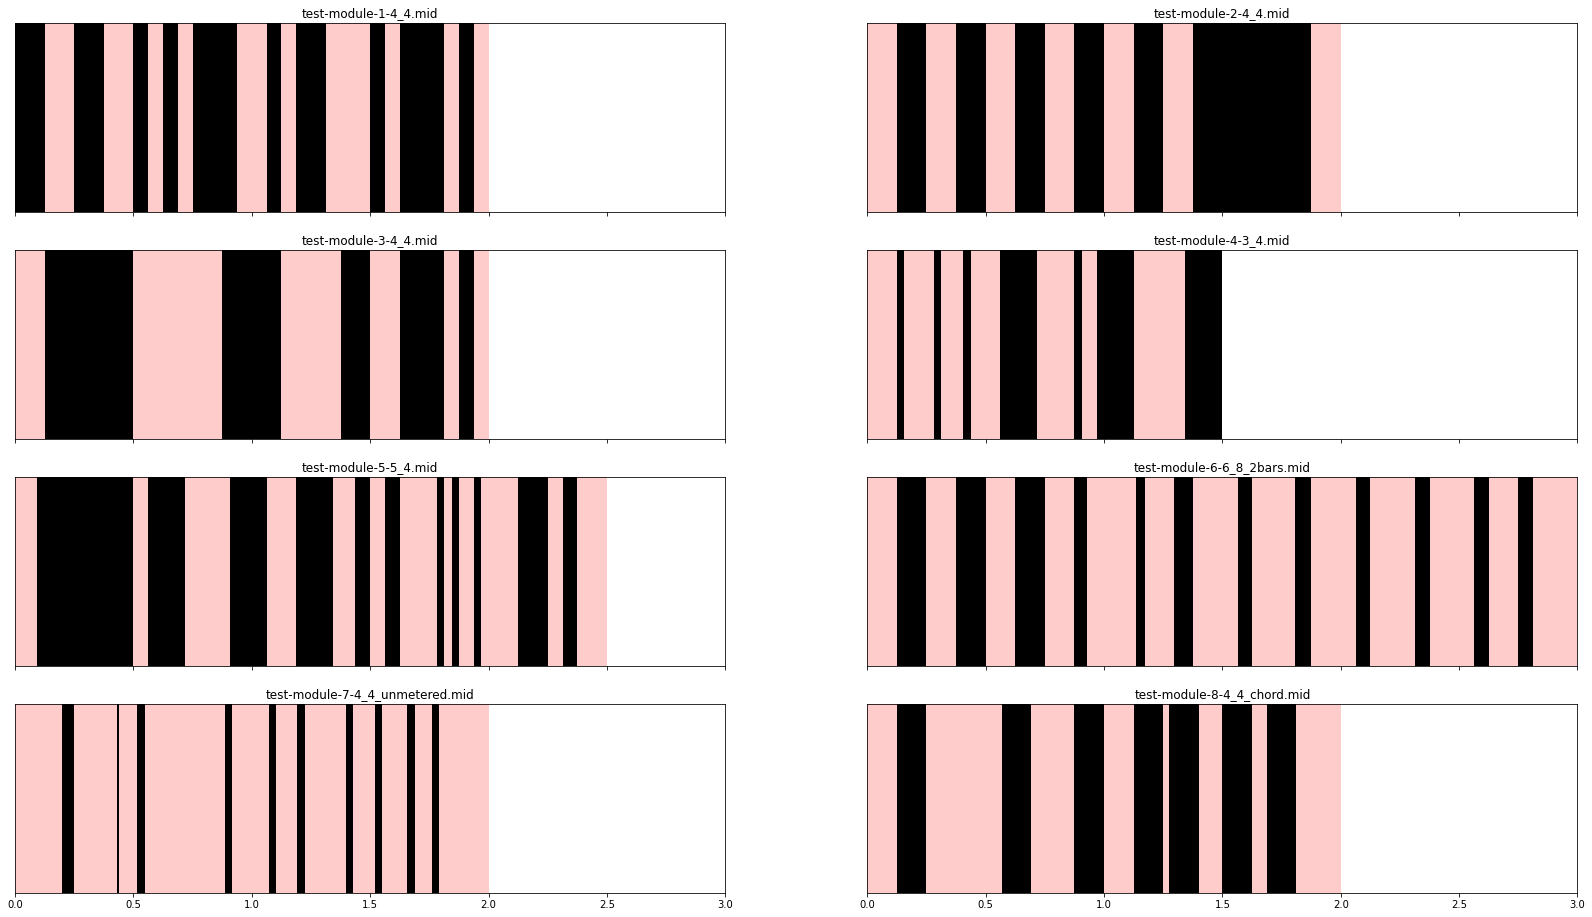

In [11]:
#@title Plot MIDI modules
#@markdown Visualize all imported modules which are used to generate the score
fig, axs = plt.subplots(math.ceil(len(midi_files) / 2), 2,
                        sharex=True,
                        sharey=True)
fig.set_figheight(math.ceil(len(midi_files) / 2)  * 4)
fig.set_figwidth(28)
axs = axs.flatten()
for index, file in enumerate(midi_files):
    notes, duration = analyze_midi(file)
    axs[index].set_title(os.path.basename(file))
    axs[index].margins(0, 0)
    axs[index].bar(0, 1, duration,
                   color="r",
                   alpha=0.2,
                   align="edge")
    axs[index].bar(notes[:, 0], 1, notes[:, 1] - notes[:, 0],
                   color="#000",
                   align="edge")
    axs[index].get_yaxis().set_visible(False)

## Generate score

In [30]:
# Analyze which modules to apply on top of the original audio onsets
# Look only for onsets which are close (+/- seconds)
similarity_threshold = 0.4

DEBUG = True


def times_from_range(times, start, end):
    return [t for t in times if t >= start and t <= end]


def calculate_similarity(source, target):
    deltas = np.array([])
    for src_event in source:
        values = [abs(src_event - trg_event) for trg_event in target]
        deltas = np.append(deltas,
                           [(similarity_threshold - v) / similarity_threshold for v in values if v < similarity_threshold])
    result = np.median(deltas) if len(deltas) > 0 else 0.0
    return result


# Find fitting module MIDI events to offset events of original sound
offset = 0
audio_duration = len(y) / sr
result_notes = np.empty((0, 2))
result_modules = []
result_statistics = []

while offset < audio_duration:
    # Analyze similarity of all modules to offsets
    start_time = offset
    results = []
    
    for index, file in enumerate(midi_files):
        # Get notes of MIDI module file and apply offset
        notes, duration = analyze_midi(file)
        notes_with_offset = np.array([t + start_time for t in notes])[:, 0]
        
        # Get all offset events between this slice (start - end time)
        end_time = start_time + duration
        times_range = times_from_range(onset_frames_times, start_time, end_time)
        if len(times_range) == 0:
            continue
            
        # Analyze similarity of original slice with module notes
        similarity = calculate_similarity(times_range, notes_with_offset)

        # Store results
        results.append({
            'similarity': similarity,
            'file': file,
            'index': index,
            'start_time': start_time,
            'end_time': end_time,
            'notes_with_offset': np.array([t + start_time for t in notes]), 
        })
        
    if len(results) == 0:
        break
        
    # Find most similar module for this section
    results_winner = max(results, key=lambda x: x['similarity'])
    
    # Add winner module to final results
    result_notes = np.append(result_notes, results_winner['notes_with_offset'], axis=0)
    result_modules.append(results_winner['index'])
    
    # Prepare offset for next iteration
    offset = results_winner['end_time']
    
    # Gather some statistics
    result_statistics.append(results_winner)
    
    # DEBUG
    if DEBUG:
        print('-----------------')
        print("{}s - {}s".format(results_winner['start_time'],
                                 results_winner['end_time']))
        print('-----------------')
        for r in results:
            win = "🗸" if results_winner['index'] == r['index'] else ""
            score = r['similarity'] if r['similarity'] != 0.0 else "%"
            print("{0:>2}: {1:.2%} {2}".format(r['index'] + 1, score, win))

-----------------
0s - 2.0s
-----------------
 1: 44.80% 
 2: 49.59% 
 3: 67.30% 🗸
 4: 47.24% 
 5: 52.54% 
 6: 52.09% 
 7: 41.79% 
 8: 44.47% 
-----------------
2.0s - 4.0s
-----------------
 1: 46.16% 
 2: 49.40% 
 3: 70.39% 🗸
 4: 57.21% 
 5: 56.67% 
 6: 47.56% 
 7: 63.20% 
 8: 55.99% 
-----------------
4.0s - 7.0s
-----------------
 1: 41.76% 
 2: 38.72% 
 3: 41.76% 
 4: 41.41% 
 5: 43.66% 
 6: 58.68% 🗸
 7: 47.19% 
 8: 47.41% 
-----------------
7.0s - 9.5s
-----------------
 1: 53.55% 
 2: 52.69% 
 3: 52.68% 
 4: 52.69% 
 5: 53.95% 🗸
 6: 52.70% 
 7: 49.88% 
 8: 52.69% 
-----------------
9.5s - 11.5s
-----------------
 1: 49.32% 
 2: 50.19% 
 3: 73.17% 🗸
 4: 72.63% 
 5: 49.72% 
 6: 47.59% 
 7: 53.66% 
 8: 50.19% 
-----------------
11.5s - 13.5s
-----------------
 1: 48.55% 
 2: 51.77% 
 3: 65.35% 🗸
 4: 64.84% 
 5: 45.82% 
 6: 41.11% 
 7: 62.80% 
 8: 51.89% 
-----------------
13.5s - 15.5s
-----------------
 1: 58.88% 
 2: 60.94% 
 3: 52.61% 
 4: 49.41% 
 5: 59.45% 
 6: 54.02% 
 7: 66.

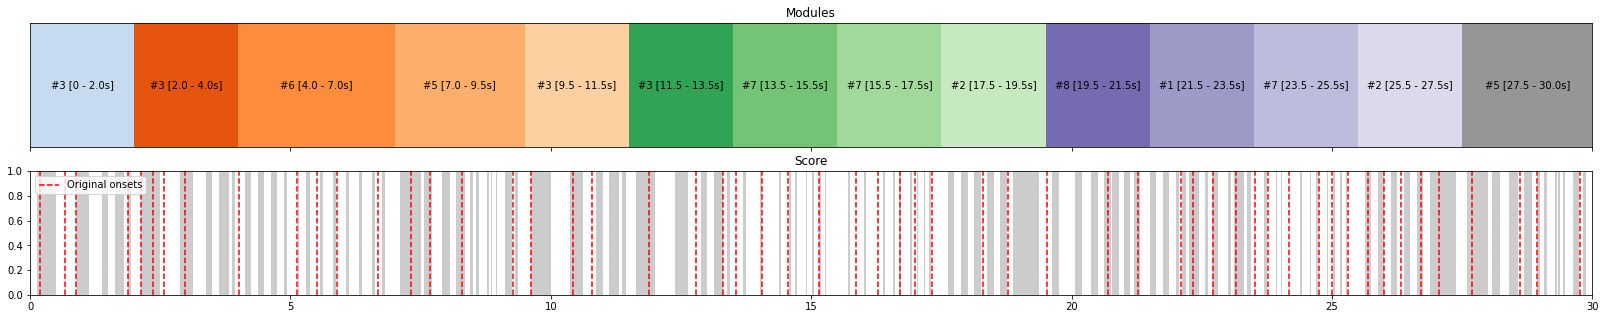

In [31]:
# Visualize final score

# Prepare plot
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(28)

# Plot modules
audio_duration = len(y) / sr
axs[0].set_title("Modules")
axs[0].get_yaxis().set_visible(False)
axs[0].margins(0, 0)
bars = axs[0].bar([m['start_time'] for m in result_statistics],
                  1,
                  [m['end_time'] - m['start_time'] for m in result_statistics],
                  color=plt.get_cmap('tab20c')(
                      np.linspace(0.15, 0.85, len(result_statistics))),
                  align="edge")
_ = axs[0].bar_label(bars,
                     labels=["#{} [{} - {}s]".format(m['index'] + 1,
                                                     m['start_time'],
                                                     m['end_time'])
                             for m in result_statistics],
                     label_type='center')

# Plot final score
axs[1].set_title("Score")
axs[1].bar(x=result_notes[:, 0],
           height=1,
           width=result_notes[:, 1] - result_notes[:, 0],
           color="#000",
           alpha=0.2,
           align="edge")
axs[1].vlines(onset_frames_times, 0, 1,
              color='r',
              label='Original onsets',
              linestyle='--')
_ = axs[1].legend()

In [34]:
# Generate final MIDI score

NOTE_PITCH = "C4"
NOTE_INSTRUMENT = "Acoustic Grand Piano"
NOTE_VELOCITY = 100

# Generate MIDI score
score = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(
    program=pretty_midi.instrument_name_to_program(NOTE_INSTRUMENT))
note_number = pretty_midi.note_name_to_number(NOTE_PITCH)
for result_note in result_notes:
    note_start = result_note[0]
    note_end = result_note[1]
    note = pretty_midi.Note(velocity=NOTE_VELOCITY,
                            pitch=note_number,
                            start=note_start,
                            end=note_end)
    instrument.notes.append(note)
    print(note)
score.instruments.append(instrument)

# Generate test with MIDI score and original audio
test_midi_audio = score.synthesize(fs=sr)
y_test = np.pad(y, (0, len(test_midi_audio) - len(y)), 'constant',
                constant_values=(0, 0))
Audio(data=test_midi_audio+y_test, rate=sr)

Note(start=0.125000, end=0.250000, pitch=60, velocity=100)
Note(start=0.250000, end=0.375000, pitch=60, velocity=100)
Note(start=0.375000, end=0.500000, pitch=60, velocity=100)
Note(start=0.875000, end=1.000000, pitch=60, velocity=100)
Note(start=1.000000, end=1.125000, pitch=60, velocity=100)
Note(start=1.375000, end=1.500000, pitch=60, velocity=100)
Note(start=1.625000, end=1.750000, pitch=60, velocity=100)
Note(start=1.750000, end=1.812500, pitch=60, velocity=100)
Note(start=1.875000, end=1.937500, pitch=60, velocity=100)
Note(start=2.125000, end=2.250000, pitch=60, velocity=100)
Note(start=2.250000, end=2.375000, pitch=60, velocity=100)
Note(start=2.375000, end=2.500000, pitch=60, velocity=100)
Note(start=2.875000, end=3.000000, pitch=60, velocity=100)
Note(start=3.000000, end=3.125000, pitch=60, velocity=100)
Note(start=3.375000, end=3.500000, pitch=60, velocity=100)
Note(start=3.625000, end=3.750000, pitch=60, velocity=100)
Note(start=3.750000, end=3.812500, pitch=60, velocity=10

In [33]:
# Save MIDI score to folder

# Select folder to store file (ex. `/content/drive/My Drive/...`)
out_dir = './'
assert os.path.exists(out_dir)

# Save MIDI file with final score
now = datetime.datetime.now()
out_file = os.path.join(out_dir, "score-{}.mid".format(now.strftime("%Y-%m-%d-%H-%M")))
score.write(out_file)
print("Stored MIDI score @ {}".format(out_file))

Stored MIDI score @ ./score-2022-06-12-16-50.mid
